In [2]:
import io
import os
import re
import sys
import csv
import gzip
import time
import json
import pickle
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
from scipy.stats import pearsonr
# import sqlite3
# from PIL import Image
import matplotlib.pyplot as plt
# from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
# from collections import Counter
# import seaborn as sns
# import matplotlib.colors as mcolors
# from matplotlib.ticker import FuncFormatter
import itertools
import collections
import pyreadr
import psa
# import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None

# Genuine logics changed from the main script were marked by string **X** in the original R files.
# Simplicity changes were marked by string **Y**

In [75]:
# original_refdir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/QUILT_ref_files/'
# auxiliary_dir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/' 

# hlatypes = pd.read_csv(auxiliary_dir + '20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
# ref_samples = pd.read_csv(auxiliary_dir + 'oneKG.samples', sep = ' ')
# all_samples = ref_samples['SAMPLE'].tolist()
# sequenced_samples = hlatypes['Sample ID'].tolist()
# ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(sequenced_samples)]
# samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
# reference_exclude_samplelist_file = ''
# if reference_exclude_samplelist_file != '':
#     samples_to_remove = samples_to_remove + lcwgsus.read_tsv_as_lst(reference_exclude_samplelist_file)

# trios = pd.read_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/integrated_call_samples_v3.20200731.ALL.ped', sep = '\t')
# trios = trios[trios['Individual ID'].isin(sequenced_samples) & trios['Paternal ID'].isin(sequenced_samples) & trios['Maternal ID'].isin(sequenced_samples)]
# trios[['Individual ID', 'Paternal ID', 'Maternal ID']].to_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/trios_filtered.tsv', sep = '\t', index = False)

In [103]:
# # QUILT phasing is in the order of maternal-paternal
# trios = pd.read_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/trios_filtered.tsv', sep = '\t')
# hlatypes = pd.read_csv(auxiliary_dir + '20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
# trios['allele1'] = 'N/A'
# trios['allele2'] = 'N/A'
# undetermined_trios = []
# gene = 'DRB1'
# def phase(r, gene, hlatypes = hlatypes):
#     kid = r['Individual ID']
#     pat = r['Paternal ID']
#     mat = r['Maternal ID']
    
#     kidtypes = hlatypes[hlatypes['Sample ID'] == kid][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
#     pattypes = hlatypes[hlatypes['Sample ID'] == mat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
#     mattypes = hlatypes[hlatypes['Sample ID'] == pat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
    
#     checks = kidtypes + pattypes + mattypes
#     if ('None' in checks) or (np.nan in checks) or (set(pattypes) == set(mattypes)):
#         undetermined_trios.append(kid)
#         r['allele1'] = 'N/A'
#         r['allele2'] = 'N/A'
#     elif kidtypes[0] == kidtypes[1]:
#         r['allele1'] = kidtypes[0]
#         r['allele2'] = kidtypes[1]
#     else:
#         if (kidtypes[0] in pattypes) and (kidtypes[0] in mattypes):
#             if kidtypes[1] in pattypes:
#                 r['allele1'] = kidtypes[0]
#                 r['allele2'] = kidtypes[1]
#             else: # kidtypes[1] in mattypes
#                 r['allele1'] = kidtypes[1]
#                 r['allele2'] = kidtypes[0]
#         elif kidtypes[0] in pattypes:
#             r['allele1'] = kidtypes[1]
#             r['allele2'] = kidtypes[0]
#         else: # kidtypes[1] in pattypes
#             r['allele1'] = kidtypes[0]
#             r['allele2'] = kidtypes[1]
#     return r

# trios = trios.apply(func = phase, args = (gene, hlatypes), axis = 1)
# # trios

In [3]:
def extract_snps_from_row(refrow, altrow, allele_pos):
    # This is still not perfect for indel detections, but we're gonna remove suspicious variants anyway so dont really care.
    # Try cope with insertions maybe
    allele_pos = np.array(allele_pos)
    refrow = refrow.to_numpy()
    altrow = altrow.to_numpy()

    variant_pos = np.unique(allele_pos[altrow != refrow])                
    vcf = pd.DataFrame(columns = ['pos', 'ref', 'alt'])
    
    if len(variant_pos) != 0:
        for i in variant_pos:
            ref_variant = ''.join(refrow[allele_pos == i])
            alt_variant = ''.join(altrow[allele_pos == i])
            if ref_variant != alt_variant and not re.search(r"\*", alt_variant):
                vcf.loc[len(vcf)] = [i, ref_variant, alt_variant]

        j = 0
        vcf2 = pd.DataFrame(columns = ['pos', 'ref', 'alt'])
        alt_arrays = vcf['alt'].str.replace('.', '').to_numpy()
        ref_arrays = vcf['ref'].str.replace('.', '').to_numpy()
        remove_rows = np.zeros(vcf.shape[0], dtype=int)

        while j < vcf.shape[0]:
            if alt_arrays[j] == "" and ref_arrays[j] != "": # Deletion from the perspective of altrow
                current_pos = vcf.iloc[j, 0]
                all1 = vcf.iloc[j, 1]
                all2 = vcf.iloc[j, 2]
                remove_rows[j] = 1
                j += 1
                while j < vcf.shape[0] and alt_arrays[j] == "":
                    all1 += vcf.iloc[j, 1]
                    all2 += vcf.iloc[j, 2]
                    remove_rows[j] = 1
                    j += 1
                vcf2.loc[len(vcf2)] = [current_pos, all1, all2]
            j += 1

        vcf = pd.concat([vcf[remove_rows == 0], vcf2])

        if vcf.shape[0] > 0:
            vcf['ref'] = vcf['ref'].str.replace('.', '').to_numpy()
            vcf['alt'] = vcf['alt'].str.replace('.', '').to_numpy()
            vcf = vcf[vcf['ref'] != vcf['alt']].sort_values(by = 'pos')
    return vcf

In [6]:
gene = 'DRB1'
region = 'DRB1'
nucleotides = ['A', 'T', 'C', 'G']
ipd_gen_file = '/Users/sus_zhang/Desktop/Suuuuuuuus/misc_data/alignments/' + gene + '_gen.txt'
if not os.path.exists(ipd_gen_file):
    ipd_gen_file = '/well/band/users/rbx225/recyclable_files/hla/alignments/' + gene + '_gen.txt'

hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
strand = hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Strand'].iloc[0]

trios = pd.read_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/trios_filtered.tsv', sep = '\t')

original_refdir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/QUILT_ref_files/'
auxiliary_dir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/' 

ref_samples = pd.read_csv(auxiliary_dir + 'oneKG.samples', sep = ' ')
hlatypes = pd.read_csv(auxiliary_dir + '20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')

ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
reference_exclude_samplelist_file = ''
if reference_exclude_samplelist_file != '':
    samples_to_remove = samples_to_remove + lcwgsus.read_tsv_as_lst(reference_exclude_samplelist_file)
# if samples_to_remove is not none, save to "hlauntyped.exclude.txt"

hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].reset_index(drop = True).sort_values(by = 'Sample ID').reset_index(drop = True)

In [7]:
with open(ipd_gen_file, "r") as file:
    lines = file.readlines()
gDNA_idx = []
names = []
i = 0
while len(gDNA_idx) < 2:
    l = lines[i]
    if 'gDNA' in l:
        gDNA_idx.append(i)
    elif l.lstrip(' ').split(' ')[0].startswith(gene + '*'):
        name = l.lstrip(' ').split(' ')[0]
        names.append(name)
    i += 1
    
first_base = int(lines[gDNA_idx[0]].split(' ')[-1].split('\n')[0])
n_alleles = gDNA_idx[1] - gDNA_idx[0] - 3

alleles_dict = {k:'' for k in names}
for i, s in enumerate(lines):
    r = s.lstrip(' ')
    if r.startswith(gene):
        r = r.rstrip(' \n')
        name = r.split(' ')[0]
        sequence = r.split(' ')[2:]
        sequence = ''.join(sequence)
        alleles_dict[name] = alleles_dict[name] + sequence

db = pd.DataFrame({key: list(value) for key, value in alleles_dict.items()}).T
db = db.drop(columns=db.columns[db.eq('|').all()])
db.columns = range(db.shape[1])

length = len(db.columns)
positions = [first_base]*length

db.loc[len(db)] = positions

r_idx = len(db) - 1
for i in db.columns[1:]:
    if db.iloc[0, i] == '.':
        db.iloc[r_idx, i] = db.iloc[r_idx, i-1]
    else:
        if db.iloc[r_idx, i-1] != -1:
            db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 1
        else:
            db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 2 # No zero in position. ATG is encoded by 1.
db.columns = db.iloc[r_idx]
db = db.iloc[:r_idx]

db = db.loc[:,db.columns >= 0] # Trims genomes before CDS, is this really necessary?
db = db.apply(lambda c: c.replace('-', c[0]) ,axis = 0)

if strand != 1:
    db.replace({'A': 't', 'C': 'g', 'G': 'c', 'T': 'a'}, inplace=True)
    db.replace({'a': 'A', 'c': 'C', 'g': 'G', 't': 'T'}, inplace=True)
    db = db.iloc[:, ::-1]
db.columns = range(db.shape[1])
    
reference_allele = 'DRB1*15:01:01:01' # We can store this somewhere if we are using that same fasta. Otherwise has to take the fasta and determine
counts = db.loc[reference_allele,:].value_counts()
aligned_bases = counts[counts.index.isin(nucleotides)].sum()

if strand == 1:
    genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Start'].iloc[0]
    start = genome_pos
else:
    genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['End'].iloc[0]
    start = genome_pos - aligned_bases + 1
end = start + aligned_bases - 1

allele_pos = [start]*db.shape[1]
for i, n in enumerate(db.loc[reference_allele,:].values[1:], start = 1):
    if n in nucleotides:
        allele_pos[i] = allele_pos[i - 1] + 1
    else:
        allele_pos[i] = allele_pos[i - 1]

# ourpos -> allele_pos
# first_row = ourrow is the index in db of the referece allele

variants_df = []
for i in range(len(db)):
    variants_df.append(extract_snps_from_row(db.loc[reference_allele,:], db.iloc[i,], allele_pos))
vcf = pd.concat(variants_df).drop_duplicates()
vcf = vcf[(vcf['ref'].isin(nucleotides)) & (vcf['alt'].isin(nucleotides))].sort_values(by = 'pos').reset_index(drop = True)

In [8]:
allele_pos = np.array(allele_pos)
dbcopy = pd.DataFrame()
aligned_df = pd.DataFrame()
variants_to_remove = []

def recode_variant(value):
    if value == '*':
        return -1
    elif value == a2:
        return 1
    else:
        return 0

for i in range(vcf.shape[0]):
    pos, a1, a2 = vcf.iloc[i, :3]
    index = np.where((allele_pos == pos))[0]
    
    if len(index) == 1:
        index = index[0]
        dbcopy[dbcopy.shape[1]] = db[index]        
        aligned_df[aligned_df.shape[1]] = db[index].apply(recode_variant)
    else:
        variants_to_remove.append(i)

vcf = vcf[~vcf.index.isin(variants_to_remove)].reset_index(drop = True) 
# This is a remedy when extract_snps_from_row fails to detect insertions. 
# For DRB1 we get 2442 variants instead of 2452, fairly good I'd say
dbfull = db
db = dbcopy

In [9]:
sample = pd.DataFrame({
    "ID_1": aligned_df.index,
    "ID_2": aligned_df.index,
    "missing": 0
})
vcf['id'] = 'chr6:' + vcf['pos'].astype(str)
haps = aligned_df.T
cond = (haps == -1).mean(axis=1) < 0.1
haps = haps[cond].reset_index(drop = True)
vcf = vcf[cond].reset_index(drop = True)

start = vcf.loc[0, 'pos']
end =vcf.loc[len(vcf) - 1, 'pos']

cond = (allele_pos >= start) & (allele_pos <= end)
allele_pos = allele_pos[cond]
dbfull = dbfull.iloc[:, np.where(cond == True)[0]]
dbfull.columns = range(dbfull.shape[1])

In [10]:
for i, a in enumerate(haps.columns):
    haps_undetermined = haps[a] == -1
    # db_determined = dbfull.loc[a, :] != "*"

    allele_col = haps[~haps_undetermined][a]
    subseted_db =  haps[~haps_undetermined] 
    pairwise_distance = subseted_db.sub(subseted_db[a], axis=0)
    counts = pairwise_distance.abs().sum().sort_values().iloc[1:]
    closest_allele_idx = 0
    substituted_nucleotides = np.array([np.nan]*np.sum(haps_undetermined))
    substituted_indices = haps_undetermined[haps_undetermined == True].index

    while np.isnan(substituted_nucleotides).any() > 0:
        closest_allele = counts.index[closest_allele_idx]
        
        target_haplotype = haps.loc[substituted_indices, closest_allele]
        substitutable = target_haplotype[target_haplotype.values != -1]
        substituted_nucleotides[substitutable.index] = substitutable.values
        closest_allele_idx += 1

    haps.loc[substituted_indices, a] = substituted_nucleotides

In [11]:
# oldsnpinfo -> prepared_vcf
# ss -> variant_alleles
# samples -> alleles
# qq -> positions

prepared_vcf = vcf
alleles = db.index
prepared_vcf['pos']  = prepared_vcf['pos'].astype(int)

variant_alleles = haps

positions = vcf['pos'].astype(float).values
zz = np.zeros(haps.shape[0]) 
for i in range(len(zz)):
    zz[i] = np.sum(allele_pos == positions[i])
zz3 = np.zeros_like(zz)
for i in range(len(zz3)):
    zz3[i] = np.sum(positions == positions[i])
filter_conditions = (zz3 == 1) & (zz == 1)

# keep sites uniquely mapping, not overlapping another SNP, with at most 10% gaps and 2-fold more non-ancestral than gaps
snpinfo = prepared_vcf.loc[filter_conditions, :].reset_index(drop = True)
snpinfo = snpinfo.iloc[:,[3, 0, 1, 2]]
variant_alleles = variant_alleles.loc[filter_conditions, :]
haps = variant_alleles.copy().reset_index(drop = True)
# haps is `n_variant \times n_alleles` df, with each entry as 0/1 representing ref/alt from the fake vcf "prepared_vcf"

In [13]:
start = snpinfo['pos'].values[0]
end = snpinfo['pos'].values[-1]
phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/oneKG.chr6.vcf.gz"
typed_samples = hlatypes['Sample ID'].tolist()

command = "bcftools view -r chr6:" + str(int(start)) + "-" + str(int(end)) + " " + phased_vcf
snp_haps = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
snp_haps = [i.split('\t') for i in snp_haps if '##' not in i]
snp_haps = pd.DataFrame(snp_haps)
snp_haps.columns = snp_haps.iloc[0]  # Set the first row as the header
snp_haps = snp_haps[1:].reset_index(drop = True)

retained_samples = snp_haps.columns.intersection(typed_samples).tolist()
hlatypes = hlatypes[hlatypes['Sample ID'].isin(retained_samples)].reset_index(drop = True)

snp_haps = snp_haps.drop(columns = ['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
snp_haps = snp_haps[(snp_haps['REF'].str.len() == 1) & (snp_haps['ALT'].str.len() == 1)]
snp_haps = snp_haps.rename(columns = {'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
snp_haps['snp'] = (snp_haps['pos'].astype(str) + snp_haps['ref'] + snp_haps['alt']).values
snp_haps['pos'] = snp_haps['pos'].astype(int)
snp_haps = snp_haps[['snp', 'pos', 'ref', 'alt'] + retained_samples]
hrcfirstalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
hrcsecondalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
for s in retained_samples:
    hrcfirstalleles[s] = snp_haps[s].str.split('|').str.get(0).astype(int)
    hrcsecondalleles[s] = snp_haps[s].str.split('|').str.get(1).astype(int)

original_variants = (snpinfo['pos'].astype(str) + snpinfo['ref'] + snpinfo['alt']).values
flipped_variants = (snpinfo['pos'].astype(str) + snpinfo['alt'] + snpinfo['ref']).values

def subset_snp_haps(hrcfirstalleles, original_variants = original_variants, flipped_variants = flipped_variants):    
    hrcfirstalleles_original = hrcfirstalleles[hrcfirstalleles['snp'].isin(original_variants)]
    hrcfirstalleles_flipped = hrcfirstalleles[hrcfirstalleles['snp'].isin(flipped_variants)]
    if len(hrcfirstalleles_flipped) == 0:
        hrcfirstalleles = hrcfirstalleles_original.drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True)
    elif len(hrcfirstalleles_flipped) == 1:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped.to_frame().T], axis = 0).sort_index()
    else:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped]).sort_index()
    hrcfirstalleles = hrcfirstalleles.sort_index().reset_index(drop = True)
    hrcfirstalleles.columns = range(hrcfirstalleles.shape[1])
    return hrcfirstalleles.T

hrcfirstalleles = subset_snp_haps(hrcfirstalleles)
hrcsecondalleles = subset_snp_haps(hrcsecondalleles)

In [14]:
samples = np.array(alleles).reshape(-1, 1)
c1 = [s[0].split('*') for s in samples]
vv = np.empty((samples.shape[0], 3), dtype=object)
ww = [c[1] for c in c1]
for i in range(len(c1)):
    vv[i, 0] = c1[i][0]
c1 = [w.split(':') for w in ww]
for i in range(len(c1)):
    vv[i, 1] = c1[i][0]
    vv[i, 2] = c1[i][1]
fourdigit = [f"{vv[i, 1]}:{vv[i, 2]}" for i in range(len(vv))]
ufourdigit = np.unique(fourdigit)
# Convert reference alleles to 4-digit resolution. vv and ww are just intermediate variables of no use
# ufourdigit is unique 4-digit alleles

haps = np.array(haps, dtype=float)
newhaps = np.empty((haps.shape[0], len(ufourdigit)))
for i in range(newhaps.shape[1]):
    tt = np.where(np.array(fourdigit) == ufourdigit[i])[0]
    if len(tt) < 2:
        tt = np.concatenate((tt, tt))
    newhaps[:, i] = np.mean(haps[:, tt], axis=1)
newhaps = pd.DataFrame(newhaps, columns = ufourdigit)

cols = snpinfo.columns.tolist()
full_vcf = snp_haps.copy()[cols[1:]]
same = pd.merge(full_vcf, snpinfo, on = cols[1:], how = 'inner')
newhaps_original = newhaps.loc[snpinfo[snpinfo['id'].isin(same['id'].values)].index,:]

snpinfo_flipped = snpinfo.iloc[:,[0, 1, 3, 2]]
snpinfo_flipped.columns = cols
flipped = pd.merge(full_vcf, snpinfo_flipped, on = cols[1:], how = 'inner')
newhaps_flipped = 1 - newhaps.loc[snpinfo_flipped[snpinfo_flipped['id'].isin(flipped['id'].values)].index,:]

if len(newhaps_flipped) == 0:
    newhaps = newhaps_original
elif len(newhaps_flipped) == 1:
    newhaps = pd.concat([newhaps_original, newhaps_flipped.to_frame().T], axis = 0).sort_index()
else:
    newhaps = pd.concat([newhaps_original, newhaps_flipped]).sort_index()
newhaps2 = newhaps.reset_index(drop = True)

In [15]:
# ourtypes -> reftypes
region_pattern = f"HLA.{region}."
cols = [i for i, col in enumerate(hlatypes.columns) if re.search(region_pattern, col)]

reftypes1 = hlatypes.iloc[:, cols[0]].astype(str).tolist()
reftypes1 = [re.sub(r"\*", "", t) for t in reftypes1]
reftypes1 = np.array(reftypes1)
vv = [t.split('/') for t in reftypes1]
for i in range(len(reftypes1)):
    reftypes1[i] = vv[i][0]

reftypes2 = hlatypes.iloc[:, cols[1]].astype(str).tolist()
reftypes2 = [re.sub(r"\*", "", t) for t in reftypes2]

vv = [t.split('/') for t in reftypes2]
for i in range(len(reftypes2)):
    reftypes2[i] = vv[i][0]
reftypes2 = np.array(reftypes2)
# vv is assigning the first hla type when it is ambiguous. What about remove those? **Y**

In [16]:
def phase_subtraction(array1, array2, indices):
    array1 = array1.iloc[:,indices].values
    array2 = array2[:, indices]
    result = np.array([np.nan]*array1.shape[0])
    for i in range(array1.shape[0]):
        if np.any(np.isnan(array1[i,:])) or np.any(np.isnan(array2[i,:])):
            tmp = np.nan
        else:
            tmp = np.sum(np.abs(array1[i,:] - array2[i,:]))
        result[i] = tmp
    return result

array([0.9, 0.8, 0.7, 0.6, 0.5])

In [78]:
types1 = np.array(pd.Series([np.nan] * len(reftypes1))) # array of length n alleles that is 1 if that 2-field is in database
types1[np.isin(reftypes1, newhaps2.columns)] = 1
predfirstalleles = np.array(pd.DataFrame(np.nan, index=range(len(types1)), columns=range(newhaps2.shape[0])))
predfirstalleles[types1 == 1, :] = newhaps2.loc[:, reftypes1[types1 == 1]].T

types2 = np.array(pd.Series([np.nan] * len(reftypes2)))
types2[np.isin(reftypes2, newhaps2.columns)] = 1
predsecondalleles = np.array(pd.DataFrame(np.nan, index=range(len(types2)), columns=range(newhaps2.shape[0])))
predsecondalleles[types2 == 1, :] = newhaps2.loc[:, reftypes2[types2 == 1]].T

obsgen = hrcfirstalleles + hrcsecondalleles
predgen = pd.DataFrame(predfirstalleles + predsecondalleles)
corr = np.empty(obsgen.shape[1])
for i in range(obsgen.shape[1]):
    with np.errstate(invalid='ignore'):
        corr[i] = obsgen.loc[:, i].corr(predgen.loc[:, i])

valid_corr_indices = np.where((corr > 0.8) & (~np.isnan(corr)))[0]

dist11 = phase_subtraction(hrcfirstalleles, predfirstalleles, valid_corr_indices)
dist12 = phase_subtraction(hrcfirstalleles, predsecondalleles, valid_corr_indices)
dist21 = phase_subtraction(hrcsecondalleles, predfirstalleles, valid_corr_indices)
dist22 = phase_subtraction(hrcsecondalleles, predsecondalleles, valid_corr_indices)

phase1 = dist11 + dist22
phase2 = dist12 + dist21

d11 = dist11
d21 = dist21
d12 = dist12
d22 = dist22

phased1 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 < 4) & (phase2 > 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase2 - phase1 > 2) & (phase1 < 4)) |
    ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2) & (d22 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2) & (d11 < 2))
)

phased2 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 > 4) & (phase2 < 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 - phase2 > 2) & (phase2 < 4)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2) & (d12 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2) & (d21 < 2))
)

# allele1 = np.where(phased1, reftypes1, np.where(phased2, reftypes2, 'None'))
# allele2 = np.where(phased1, reftypes2, np.where(phased2, reftypes1, 'None'))

phased1old = phased1.copy()
phased2old = phased2.copy()
oldphase1 = phase1.copy()
oldphase2 = phase2.copy()

In [82]:
phase_df1 = pd.DataFrame({'Sample': hlatypes['Sample ID'].values, 'phase1': phased1, 'phase2': phased2})

# plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
# plt.colorbar()

TypeError: only integer scalar arrays can be converted to a scalar index

In [88]:
alleles = np.append(allele1, allele2)
nameset = np.unique(alleles[alleles != 'None'])

hrcalleles = pd.concat([hrcfirstalleles, hrcsecondalleles])

predmat = np.zeros((len(nameset), obsgen.shape[1]))
for i, name in enumerate(nameset):
    predmat[i, :] = np.mean(hrcalleles.iloc[alleles == name, :], axis=0)

predmatallele1 = np.full((len(reftypes1), obsgen.shape[1]), np.nan)
predmatallele2 = np.full((len(reftypes1), obsgen.shape[1]), np.nan)

for i in range(len(reftypes1)):
    if reftypes1[i] in nameset: 
        predmatallele1[i, :] = predmat[np.where(nameset == reftypes1[i])[0][0], :]
    if reftypes2[i] in nameset: 
        predmatallele2[i, :] = predmat[np.where(nameset == reftypes2[i])[0][0], :]

dist11 = np.sum(np.abs(hrcfirstalleles - predmatallele1) > 0.9, axis=1)
dist12 = np.sum(np.abs(hrcfirstalleles - predmatallele2) > 0.9, axis=1)
dist21 = np.sum(np.abs(hrcsecondalleles - predmatallele1) > 0.9, axis=1)
dist22 = np.sum(np.abs(hrcsecondalleles - predmatallele2) > 0.9, axis=1)

phase1b = dist11 + dist22
phase2b = dist12 + dist21

d11 = dist11
d21 = dist21
d12 = dist12
d22 = dist22

phased1b = (
    (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b < phase2b)) |
    ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2))
)

phased2b = (
    (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b > phase2b)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2))
)

update = ~phased1 & ~phased2
phased1[update] = phased1b[update]
phased2[update] = phased2b[update]

In [90]:
phase_df2 = pd.DataFrame({'Sample': hlatypes['Sample ID'].values, 'phase1': phased1, 'phase2': phased2})
phase_df2

,Sample,phase1,phase2
0,HG00096,False,True
1,HG00097,False,True
2,HG00099,False,True
3,HG00100,True,False
4,HG00101,True,False
...,...,...,...
2563,NA21137,False,True
2564,NA21141,False,True
2565,NA21142,False,True
2566,NA21143,False,True


In [92]:
phase_df2[(phase_df2['phase1'] == False) & ((phase_df2['phase2'] == False))]

,Sample,phase1,phase2
250,HG00598,False,False
333,HG01054,False,False
457,HG01363,False,False
566,HG01619,False,False
824,HG02143,False,False
857,HG02232,False,False
929,HG02390,False,False
1084,HG02763,False,False
1160,HG02982,False,False
1199,HG03078,False,False


In [31]:
phase2b[2]

94

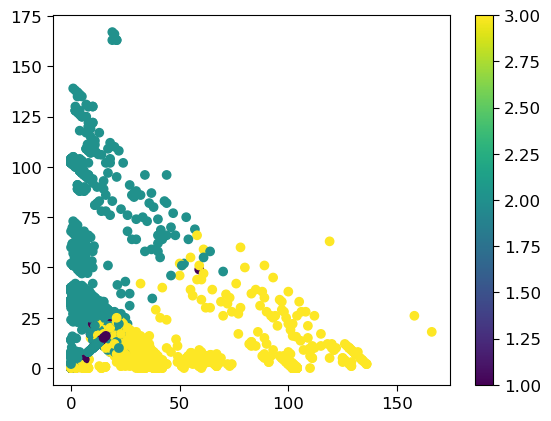

In [22]:
plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
plt.colorbar()

In [23]:
unphased_samples = (phased1 != True) & (phased2 != True)
unphased_samples_to_remove = hlatypes['Sample ID'].to_numpy()[unphased_samples]
samples_to_remove = samples_to_remove + list(unphased_samples_to_remove)

In [182]:
# QUILT phasing is in the order of maternal-paternal
trios['allele1'] = 'N/A'
trios['allele2'] = 'N/A'
undetermined_trios = []

def phase(r, gene, hlatypes = hlatypes):
    kid = r['Individual ID']
    pat = r['Paternal ID']
    mat = r['Maternal ID']
    
    kidtypes = hlatypes[hlatypes['Sample ID'] == kid][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
    pattypes = hlatypes[hlatypes['Sample ID'] == mat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
    mattypes = hlatypes[hlatypes['Sample ID'] == pat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
    
    checks = kidtypes + pattypes + mattypes
    if ('None' in checks) or (np.nan in checks) or (set(pattypes) == set(mattypes)):
        undetermined_trios.append(kid)
        r['allele1'] = 'N/A'
        r['allele2'] = 'N/A'
    elif kidtypes[0] == kidtypes[1]:
        r['allele1'] = kidtypes[0]
        r['allele2'] = kidtypes[1]
    else:
        if (kidtypes[0] in pattypes) and (kidtypes[0] in mattypes):
            if kidtypes[1] in pattypes:
                r['allele1'] = kidtypes[0]
                r['allele2'] = kidtypes[1]
            else: # kidtypes[1] in mattypes
                r['allele1'] = kidtypes[1]
                r['allele2'] = kidtypes[0]
        elif kidtypes[0] in pattypes:
            r['allele1'] = kidtypes[1]
            r['allele2'] = kidtypes[0]
        else: # kidtypes[1] in pattypes
            r['allele1'] = kidtypes[0]
            r['allele2'] = kidtypes[1]
    return r

trios = trios.apply(func = phase, args = (gene, hlatypes), axis = 1)
# trios

kgp_samples_idx = hlatypes.index[hlatypes['Sample ID'].isin(trios['Individual ID'])].to_numpy()
kgp_samples_phase = phased1[kgp_samples_idx]

phased_res = pd.DataFrame({'Sample ID': trios['Individual ID'].tolist(), 'allele1': reftypes1[kgp_samples_idx], 'allele2': reftypes2[kgp_samples_idx]})

for i in range(len(phased_res)):
    if kgp_samples_phase[i] == False:
        tmp = phased_res.iloc[i, 1]
        phased_res.iloc[i, 1] = phased_res.iloc[i, 2]
        phased_res.iloc[i, 2] = tmp

phased_res

,Sample ID,allele1,allele2
0,HG00702,14:54,09:01
1,HG00733,11:04,03:01
2,HG02024,12:02,12:02
3,NA12878,03:01,01:01
4,NA19240,12:01,16:02
5,NA19675,07:01,03:01
6,NA19685,01:02,14:06


In [183]:
trios

,Individual ID,Paternal ID,Maternal ID,allele1,allele2
0,HG00702,HG00656,HG00657,14:54,09:01
1,HG00733,HG00731,HG00732,11:04,03:01
2,HG02024,HG02026,HG02025,12:02,12:02
3,NA12878,NA12891,NA12892,03:01,01:01
4,NA19240,NA19239,NA19238,12:01,16:02
5,NA19675,NA19679,NA19678,07:01,03:01
6,NA19685,NA19661,NA19660,01:02,14:06
